# **Algoritmi Genetici per l'ottimizzazione di modelli di Machine Learning (pt.2)**

Questo Notebook contiene la seconda parte del progetto *Algoritmi Genetici per l'ottimizzazione di modelli di Machine Learning*.

## **Utilità**

### Import

In [1]:
import itertools
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from itersel import *
from genetic.problem import Element, GAProblem, MultiThreadGAProblem
from genetic.evolution import GeneticSolver, MultiThreadGeneticSolver
from genetic.crossover import uniform_crossover
import matplotlib.pyplot as plt

### Funzione Obiettivo

In [2]:
def eval_lin_reg(X: pd.DataFrame, Y: pd.Series, return_model: bool = False):
    '''
        Restituisce il valore del criterio di valutazione selezionato di un modello 
        di Regressione Lineare costruito sulla base dei dati X ed Y.

        Parametri:

        - `X`: Variabili di input del modello di Regressione Lineare
        - `Y`: Variabili di output del modello di Regressione Lineare
        - `return_model`: indica se il modello costruito deve essere restituito dalla funzione. Default = `False`

        Return:

        La funzione restituisce un oggetto contenente i valori dei criteri di selezione, 
        il Mean Squared Error, il Residual Sum of Squares ed il modello costruito (se `return_model = True`).
    '''
    # Definizione del modello
    model = LinearRegression()
    # Addestramento
    model.fit(X, Y)
    # Predizione
    Y_pred = model.predict(X)
    # Mean Squared Error
    mse = mean_squared_error(Y, Y_pred)
    # Residual Sum of Squares
    rss = np.sum((Y - Y_pred) ** 2)
    # Numero di parametri del modello
    num_params = len(model.coef_) + 1
    # Numero di record del dataset
    n = len(Y)
    # AIC
    aic = n * np.log(mse) + 2 * num_params
    # BIC
    bic = n * np.log(mse) + np.log(n) * num_params
    # Adj. R^2
    Y_bar = np.full(shape = (n,), fill_value = np.sum(Y, axis = 0) / n)
    tss = np.sum((Y - Y_bar) ** 2, axis = 0)
    rss = np.sum((Y - Y_pred) ** 2, axis = 0)
    adjr = 1 - (rss / (n - num_params - 1)) / (tss / (n - 1))
    
    result = {
        AIC:aic, BIC:bic, ADJ_R2:adjr, RSS:rss, "_coef": model.coef_
    }
    if return_model:
        result["model"] = model
    return result

### Scheduler di probabilità

In [7]:
def pmut_sched(p_mut, epoch, best, last_update, fit_history):
    '''
        Scheduler della probabilità di mutazione
    '''
    if last_update == 0:
        return 0.1
    return min(0.9, p_mut + 0.05)

def pcross_sched(p_cross, epoch, best, last_update, fit_history):
    '''
        Scheduler della probabilità di crossover
    '''
    if last_update == 0:
        return 0.9
    return max(0.1, p_cross - 0.05)

## **Applicazione n° 2**

#### Dataset

In [5]:
car_price = pd.read_csv("dataset/car_price_clean.csv")

X_car = car_price.drop(["MSRP"], axis = 1)
Y_car = np.log1p(car_price["MSRP"])

X_car = pd.get_dummies(X_car, drop_first=True)
X_car.head()

,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Age,Engine Fuel Type_electric,Engine Fuel Type_flex-fuel (premium unleaded recommended/E85),Engine Fuel Type_flex-fuel (premium unleaded required/E85),...,Vehicle Style_Convertible,Vehicle Style_Convertible SUV,Vehicle Style_Coupe,Vehicle Style_Crew Cab Pickup,Vehicle Style_Extended Cab Pickup,Vehicle Style_Passenger Minivan,Vehicle Style_Passenger Van,Vehicle Style_Regular Cab Pickup,Vehicle Style_Sedan,Vehicle Style_Wagon
0,335.0,6.0,2.0,26,19,3916,6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,300.0,6.0,2.0,28,19,3916,6,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,300.0,6.0,2.0,28,20,3916,6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,230.0,6.0,2.0,28,18,3916,6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,230.0,6.0,2.0,28,18,3916,6,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Selezione Iterativa

In [6]:
# AIC
best_fAIC, _ = forward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
best_bAIC, _ = backward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
best_sAIC, _ = stepwise_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
# BIC
best_fBIC, _ = forward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
best_bBIC, _ = backward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
best_sBIC, _ = stepwise_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
# Adj. R2
best_fR2, _ = forward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
best_bR2, _ = backward_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
best_sR2, _ = stepwise_selection(X_car, Y_car, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)

### Algoritmo Genetico Parallelo

Definizione del problema per l'esecuzione parallela

In [8]:
class ParallelModelSelectionProblem(MultiThreadGAProblem):
    '''
        Definizione di un problema di Model Selection risolvibile tramite Algoritmi Genetici Paralleli
    '''
    def __init__(self, X: pd.DataFrame, Y: pd.Series, colnames: np.ndarray = None, criterion: int = AIC, transform_categorical: bool = False, p_True:float = 0.5) -> None:
        self.X = X
        self.Y = Y
        if colnames == None:
            self.colnames = self.X.columns.to_numpy()
        else:
            self.colnames = colnames
        self.sol_dim = len(self.colnames)
        if criterion != AIC and criterion != BIC and criterion != ADJ_R2:
            raise ValueError("Invalid selection criterion. Must be AIC or BIC or ADJ_R2.")
        self.criterion = criterion
        self.transform_categorical = transform_categorical
        self.p_True = p_True

    def correct_solution(self, sol: np.ndarray):
        '''
            Funzione di correzione delle soluzioni.

            Se tutti gli elementi della soluzione sono `False`, 
            viene scelto casualmente un elemento ed impostato a `True`
        '''
        if np.sum(sol) == 0:
            sol[random.randrange(0, self.sol_dim)] = True

    def init_pop(self, n: int) -> list:
        pop = []
        for _ in range(n):
            elm = np.random.choice([False, True], self.sol_dim, replace = True, p = [1-self.p_True, self.p_True])
            # Correzione
            self.correct_solution(elm)
            pop.append(elm)
        return pop

    def evaluate(self, elm: Element, thread_idx: int = 0) -> None:
        sol = elm.solution
        # Costruzione del dataset a partire dalla soluzione
        cols = self.colnames[sol]
        X_eval = self.X[cols]
        if self.transform_categorical:
            X_eval = pd.get_dummies(X_eval)
        # Valutazione del modello
        result = eval_lin_reg(X_eval, self.Y, return_model = False)
        elm.fitness = result[self.criterion]

    def crossover(self, sol1: object, sol2: object, thread_idx: int = 0) -> 'list | tuple':
        _sol1 = self.copy(sol1)
        _sol2 = self.copy(sol2)
        # Crossover uniforme
        ch1, ch2, _ = uniform_crossover(_sol1, _sol2)
        ch1 = np.array(ch1, dtype=bool)
        ch2 = np.array(ch2, dtype=bool)
        # Correzione
        self.correct_solution(ch1)
        self.correct_solution(ch2)

        return ch1, ch2

    def mutate(self, sol: object, thread_idx: int = 0) -> object:
        _sol = self.copy(sol)
        # Indice casuale
        idx = random.randrange(0, self.sol_dim)
        # Negazione
        _sol[idx] = not _sol[idx]
        # Correzione
        self.correct_solution(_sol)
        return _sol

    def copy(self, sol: object, thread_idx: int = 0) -> object:
        return np.copy(sol)

Risoluzione parallela

In [9]:
problem = ParallelModelSelectionProblem(X = X_car, 
                                        Y = Y_car,
                                        criterion = AIC)
pop_size = 150
epochs = 30
solver = MultiThreadGeneticSolver(problem, 
                                    pop_size = pop_size, 
                                    p_cross = 0.9, 
                                    p_mut = 0.3,
                                    pop_update_strategy="best_n", 
                                    selection_strategy="roulette_wheel",
                                    use_elit = True,
                                    minimize = True,
                                    n_jobs = 6)
solver.use_p_mut_scheduler(pmut_sched)
solver.use_p_cross_scheduler(pcross_sched)

print("AIC")
best_gaAIC = solver.run(epochs = epochs, verbose = False, seed = 123)
AIC_fitH = solver.fit_history
AIC_lastUpdate = epochs - solver.last_update

print("BIC")
solver.problem.criterion = BIC
solver.minimize = True
best_gaBIC = solver.run(epochs = epochs, verbose = False, seed = 123)
BIC_fitH = solver.fit_history
BIC_lastUpdate = epochs - solver.last_update

print("Adjusted R^2")
solver.problem.criterion = ADJ_R2
solver.minimize = False
best_gaR2 = solver.run(epochs = epochs, verbose = False, seed = 123)
R2_fitH = solver.fit_history
R2_lastUpdate = epochs - solver.last_update

print("Done")

AIC
BIC
Adjusted R^2
Done


Visualizzazione

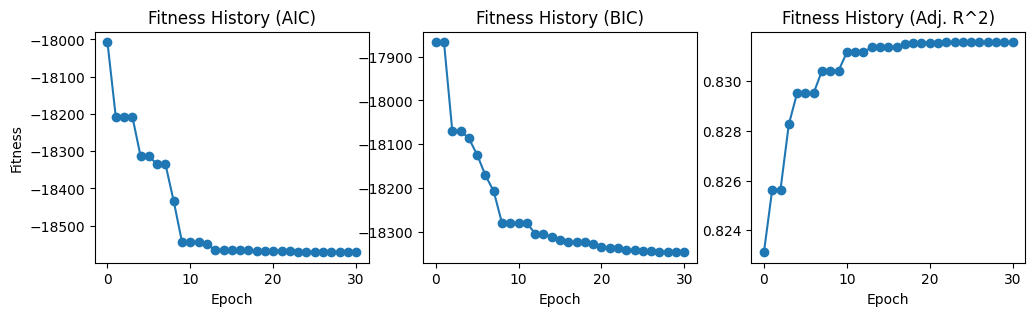

In [12]:
plt.figure(figsize = (12,3))
plt.subplot(1, 3, 1)
plt.plot(AIC_fitH, "o-")
plt.title("Fitness History (AIC)")
plt.xlabel("Epoch")
plt.ylabel("Fitness")

plt.subplot(1, 3, 2)
plt.plot(BIC_fitH, "o-")
plt.title("Fitness History (BIC)")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
plt.plot(R2_fitH, "o-")
plt.title("Fitness History (Adj. R^2)")
plt.xlabel("Epoch")

plt.show()

#### Confronto

In [13]:
res_df = pd.DataFrame({"Forward": [best_fAIC[CRT_VALUE], best_fBIC[CRT_VALUE], best_fR2[CRT_VALUE]],
                        "Backward": [best_bAIC[CRT_VALUE], best_bBIC[CRT_VALUE], best_bR2[CRT_VALUE]],
                        "Stepwise": [best_sAIC[CRT_VALUE], best_sBIC[CRT_VALUE], best_sR2[CRT_VALUE]],
                        "GA":[best_gaAIC.fitness, best_gaBIC.fitness, best_gaR2.fitness]}, index = ["AIC", "BIC", "ADJ. R2"])
res_df

,Forward,Backward,Stepwise,GA
AIC,-18570.578913,-18571.334518,-18570.578913,-18571.334518
BIC,-18317.377685,-18346.153649,-18317.377685,-18346.153649
ADJ. R2,0.831575,0.831575,0.831575,0.831575


## **Combinazione degli algoritmi**

Un vantaggio offerto dagli algoritmi genetici stà nella loro flessibilità.

Questa caratteristica permette di combinare facilmente questi algoritmi con le strategie iterative al fine di migliorare la soluzione calcolata da quest'ultime.

Modifichiamo il problema per gestire l'inserimento di una soluzione personalizzata all'interno della popolazione iniziale.

In [24]:
class ModelSelectionProblem(GAProblem):
    '''
        Definizione di un problema di Model Selection risolvibile tramite Algoritmi Genetici
    '''
    def __init__(self, X: pd.DataFrame, Y: pd.Series, colnames: np.ndarray = None, criterion: int = AIC, transform_categorical: bool = False,
                       inject: np.ndarray = None, p_True:float = 0.5) -> None:
        self.X = X
        self.Y = Y
        if colnames == None:
            self.colnames = self.X.columns.to_numpy()
        else:
            self.colnames = colnames
        self.sol_dim = len(self.colnames)
        if criterion != AIC and criterion != BIC and criterion != ADJ_R2:
            raise ValueError("Invalid selection criterion. Must be AIC or BIC or ADJ_R2.")
        self.criterion = criterion
        self.transform_categorical = transform_categorical
        self.inject = inject   
        self.p_True = p_True

    def correct_solution(self, sol: np.ndarray):
        '''
            Funzione di correzione delle soluzioni.

            Se tutti gli elementi della soluzione sono `False`, 
            viene scelto casualmente un elemento ed impostato a `True`
        '''
        if np.sum(sol) == 0:
            sol[random.randrange(0, self.sol_dim)] = True

    def init_pop(self, n: int) -> list:
        if isinstance(self.inject, np.ndarray) and self.inject.any():
            pop = [self.inject]
        else:
            pop = []
        for _ in range(n):
            elm = np.random.choice([False, True], self.sol_dim, replace = True, p = [1-self.p_True, self.p_True])
            # Correzione
            self.correct_solution(elm)
            pop.append(elm)
        return pop

    def evaluate(self, elm: Element) -> None:
        sol = elm.solution
        # Costruzione del dataset a partire dalla soluzione
        cols = self.colnames[sol]
        X_eval = self.X[cols]
        if self.transform_categorical:
            X_eval = pd.get_dummies(X_eval)
        # Valutazione del modello
        result = eval_lin_reg(X_eval, self.Y, return_model = False)
        elm.fitness = result[self.criterion]

    def crossover(self, sol1: object, sol2: object) -> 'list | tuple':
        _sol1 = self.copy(sol1)
        _sol2 = self.copy(sol2)
        # Crossover uniforme
        ch1, ch2, _ = uniform_crossover(_sol1, _sol2)
        ch1 = np.array(ch1, dtype=bool)
        ch2 = np.array(ch2, dtype=bool)
        # Correzione
        self.correct_solution(ch1)
        self.correct_solution(ch2)

        return ch1, ch2

    def mutate(self, sol: object) -> object:
        _sol = self.copy(sol)
        # Indice casuale
        idx = random.randrange(0, self.sol_dim)
        # Negazione
        _sol[idx] = not _sol[idx]
        # Correzione
        self.correct_solution(_sol)
        return _sol

    def copy(self, sol: object) -> object:
        return np.copy(sol)

Consideriamo il primo dataset ed aggiungiamo i termini di interazione

In [51]:
credit_df = pd.read_csv("dataset/credit.csv")
X_credit = credit_df.drop("Balance", axis = 1)
Y_credit = np.log1p(credit_df["Balance"])
X_credit = pd.get_dummies(X_credit, drop_first=True)

polyFeat = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_credit_poly = polyFeat.fit_transform(X_credit)
X_credit_poly = pd.DataFrame(X_credit_poly)
X_credit_poly.columns = polyFeat.get_feature_names_out()
X_credit_poly.head()

,Income,Limit,Rating,Cards,Age,Education,Gender_Male,Student_Yes,Married_Yes,Ethnicity_Asian,...,Gender_Male Student_Yes,Gender_Male Married_Yes,Gender_Male Ethnicity_Asian,Gender_Male Ethnicity_Caucasian,Student_Yes Married_Yes,Student_Yes Ethnicity_Asian,Student_Yes Ethnicity_Caucasian,Married_Yes Ethnicity_Asian,Married_Yes Ethnicity_Caucasian,Ethnicity_Asian Ethnicity_Caucasian
0,14.891,3606.0,283.0,2.0,34.0,11.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,106.025,6645.0,483.0,3.0,82.0,15.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,104.593,7075.0,514.0,4.0,71.0,11.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,148.924,9504.0,681.0,3.0,36.0,11.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55.882,4897.0,357.0,2.0,68.0,16.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Applichiamo il *Forward Selection* per la minimizzazione dell'indice AIC

In [46]:
# AIC
best_fAIC, _ = forward_selection(X_credit_poly, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
print(best_fAIC[CRT_VALUE])

-57.14131501635448


Utilizziamo l'algoritmo genetico per migliorare la soluzione.

AIC = -68.90054346214949


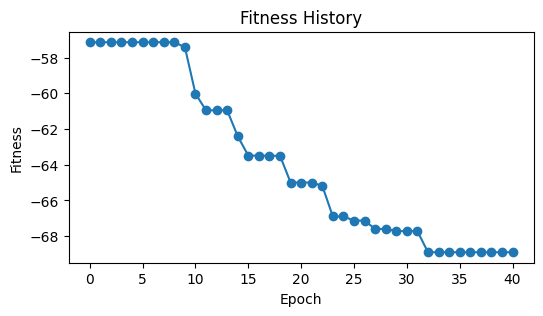

In [50]:
epochs = 40
problem = ModelSelectionProblem(X = X_credit_poly, 
                                Y = Y_credit,
                                criterion = AIC,
                                inject=best_fAIC["comb"].astype(bool))
solver = GeneticSolver(problem, 
                        pop_size = 50, 
                        p_cross = 0.9, 
                        p_mut = 0.1,
                        pop_update_strategy="best_n",
                        minimize = True)
solver.use_p_mut_scheduler(pmut_sched)
solver.use_p_cross_scheduler(pcross_sched)

best_gaAIC = solver.run(epochs = epochs, verbose = False, seed = 123)
AIC_fitH = solver.fit_history
AIC_lastUpdate = epochs - solver.last_update
print("AIC =", best_gaAIC.fitness)

plt.figure(figsize = (6,3))
plt.plot(solver.fit_history, "o-")
plt.title("Fitness History")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.show()